## Field Profitability Index Prediction
---

In [260]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams['figure.figsize'] = (15.0, 7.0)
sns.set_theme()

In [261]:
esdc_raw = pd.read_excel('Data/esdc_raw.xlsx')
esdc_raw.head()

,fluid,field_name,operator,project_status,project_level,inplace,depth,temp,poro,perm,...,api_dens,visc,cap_cost,opr_cost,total_cost,avg_fluid_rate,location,region,NPV,PI
0,Gas,ALAS TUA WEST,EXXONMOBIL CEPU LTD.,ONSHORE,X1. Discovery under Evaluation,280.00,5627.0,NaN,0.231540,396.2948,...,0.654735,0.0,88.121670,7.390892,95.512562,61.136190,Jawa Timur,Jawa,219.373400,2.296802
1,Gas,APNC,PT PERTAMINA HULU ENERGI OFFSHORE NORTH WEST JAVA,OFFSHORE,X3. Development Not Viable,5.00,1588.0,NaN,0.371649,975.0449,...,0.769757,0.0,16.350820,0.482584,16.833404,8.260639,Jawa Barat,Jawa,6.763115,0.401768
2,Gas,APNX,PT PERTAMINA HULU ENERGI OFFSHORE NORTH WEST JAVA,OFFSHORE,X3. Development Not Viable,17.31,NaN,NaN,0.350870,1985.5620,...,0.774667,0.0,31.212980,5.444560,36.657540,0.209892,Jawa Barat,Jawa,25.005370,0.682134
3,Gas,BEKAPAI,PT PERTAMINA HULU MAHAKAM,BOTH,E8. Further Development Not Viable,7135.00,6383.0,76.45,0.201267,619.7617,...,0.783749,0.0,7.269243,15.765420,23.034663,15.833870,Selat Makasar,Kalimantan,3.810051,0.165405
4,Gas,BENTU DEEP,EMP BENTU LTD.,ONSHORE,X1. Discovery under Evaluation,15.90,2067.0,NaN,0.213011,108.1771,...,0.710626,0.0,6.147158,1.867879,8.015037,6.929915,Riau,Sumatera,112.446500,14.029442


In [262]:
esdc_raw.PI.count()

790

---
__Data Preprocessing__

In [263]:
total = esdc_raw.isnull().sum().sort_values(ascending=False)
percent = (esdc_raw.isnull().sum()/esdc_raw.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
temp,392,49.620253
depth,128,16.202532
region,56,7.088608
field_name,1,0.126582
fluid,0,0.000000
visc,0,0.000000
NPV,0,0.000000
location,0,0.000000
avg_fluid_rate,0,0.000000
total_cost,0,0.000000


> We have 4 major missing values. In oil and gas industry those top 3 variables are crucial because they are often related to development cost and then PI. To obtain a realiable model in PI prediction we decided to solve these issues

_Region_

> We notice that 56 region's data are missing, but when we look at those data we find it is difficult to tie the region by using another features. Despite missing values we decide to exclude those 56 data from dataset because they just represent arround 7% of total. This deletion refeals some dilemmas that we are aiming to use as many as possible datas but we are bounded to classification problem that the model we are aiming to make is capable in making prediction in PI value for a certain region so we conclude that inputation in region could lead to model degradation and quality issue.

In [264]:
esdc_raw = esdc_raw.loc[~esdc_raw.region.isna(), :]

_Temperature & Depth_

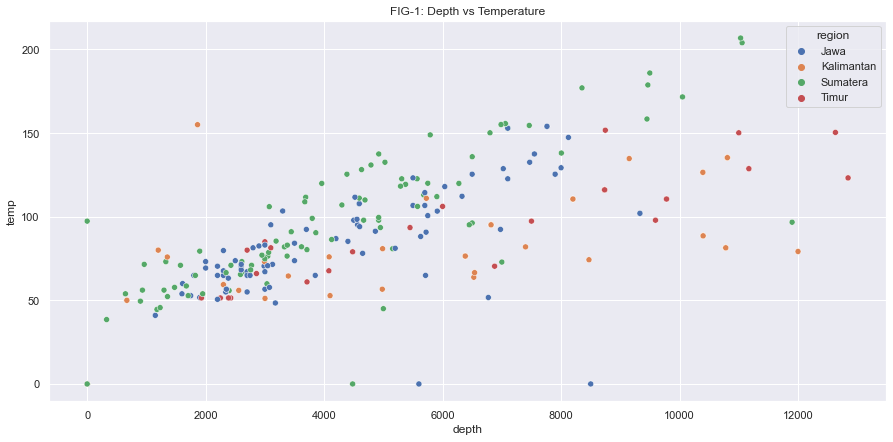

In [265]:
sns.scatterplot(x=esdc_raw.depth, y=esdc_raw.loc[~esdc_raw.temp.isna(), 'temp'], hue=esdc_raw.region)
plt.title('FIG-1: Depth vs Temperature');

> `Depth` has strong relation to `temp` as the drill string going deeper and so does the temperature. We can use this natural phenomena to predict temperature by using `depth`. As predictor, we have to solve `depth` at first to eliminate those missing datas, inconsistencies & outliers.

> FIG-2 shows the depth distribution for indonesian oil & gas field (reservoir) categorized by their location and project status whether it is located on offshore or onshore or both. From FIG-2 we are informed that the depth could vary depending on its location and region.

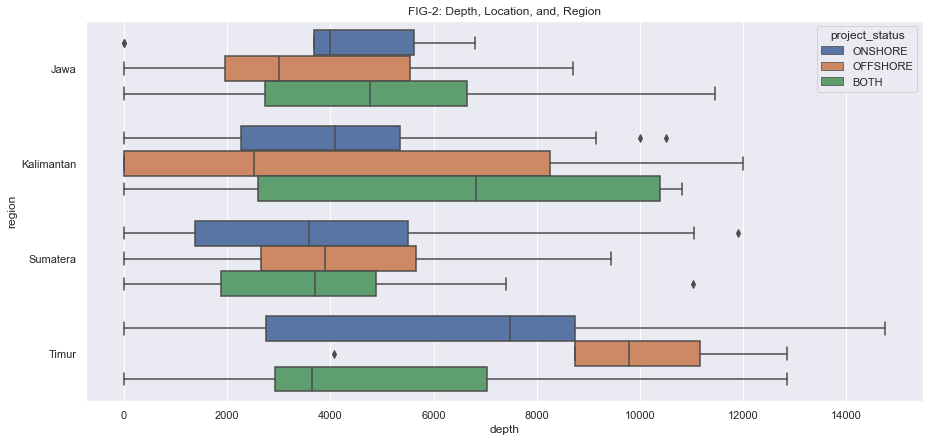

In [266]:
sns.boxplot(x=esdc_raw.depth, y=esdc_raw.region, hue=esdc_raw.project_status)
plt.title('FIG-2: Depth, Location, and, Region');

> On FIG-2 we notice that some anomalies exist and need to be solved. First issue relate to depth that has value == 0 which is impossible to have such shallow oil/ gas deposite so we will replace those values as well as NAN (second issue) by using region-project_status clustered median. We believe median is suitable as replacement because based on business knowledge those value are consistent. Moving to eastern Indonesia we are expecting deeper sea and reservoir but not in Jawa-Kalimantan-Sumatera whose median values are quite similar.

> The code below aims to calculate median value of `depth` for each region and their `project_status`. This code excludes depth==0 to obtain the right median values

In [267]:
jawa = esdc_raw.loc[(esdc_raw.depth != 0) & (esdc_raw.region == 'Jawa')].groupby('project_status')['depth'].median()
kalimantan = esdc_raw.loc[(esdc_raw.depth != 0) & (esdc_raw.region == 'Kalimantan')].groupby('project_status')['depth'].median()
sumatera = esdc_raw.loc[(esdc_raw.depth != 0) & (esdc_raw.region == 'Sumatera')].groupby('project_status')['depth'].median()
timur = esdc_raw.loc[(esdc_raw.depth != 0) & (esdc_raw.region == 'Timur')].groupby('project_status')['depth'].median()

> By having Grouby variable on region code above we are able to inpute median value to replace either NaN and 0 on `depth`. The code below show how it is done

In [268]:
esdc_raw.loc[((esdc_raw.depth == 0) | (esdc_raw.depth.isna())), 'depth'] = esdc_raw.apply(lambda row: jawa[row['project_status']] if (row['region'] == 'Jawa')  else
                    kalimantan[row['project_status']] if (row['region'] == 'Kalimantan') else
                    sumatera[row['project_status']] if (row['region'] == 'Sumatera') else
                    timur[row['project_status']] if (row['region'] == 'Timur') else row['depth'], axis=1)

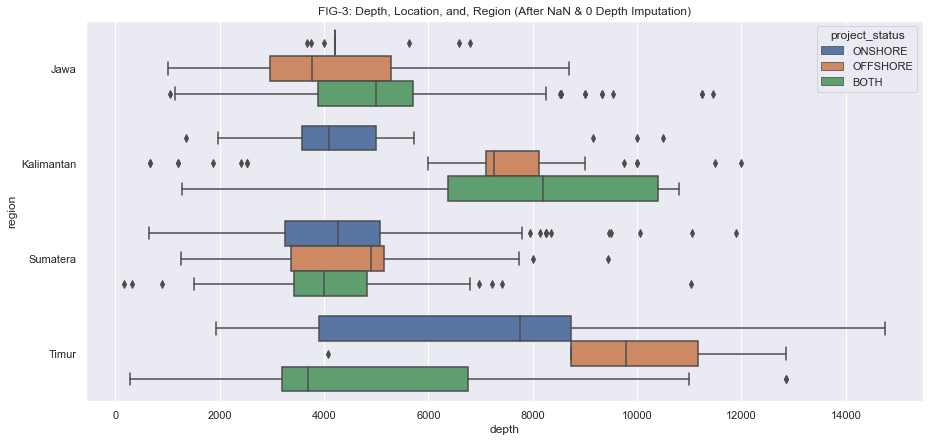

In [269]:
sns.boxplot(x=esdc_raw.depth, y=esdc_raw.region, hue=esdc_raw.project_status)
plt.title('FIG-3: Depth, Location, and, Region (After NaN & 0 Depth Imputation)');

> Sanitiy Check after 0 & NaN `depth` imputation

In [270]:
esdc_raw.loc[esdc_raw.depth == 0, ['depth', 'temp', 'location', 'region', 'project_status']].value_counts()

Series([], dtype: int64)

In [271]:
esdc_raw.loc[esdc_raw.depth.isna(), ['depth', 'temp', 'location', 'region', 'project_status']].value_counts()

Series([], dtype: int64)

Temperature

> As mentioned above that `temp` has strong relation with `depth` lineary and this phenomenon has been known and confirmed by geological knowledge and petroleum physics so we are going to predict `temp` and doing inputation for missing value and 0 by using linear regression

In [272]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [273]:
mod_1 = ols("temp ~ depth", data = esdc_raw.loc[~esdc_raw.temp.isna(), :])
res_1 = mod_1.fit(cov_type='HC3')
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     86.00
Date:                Sun, 19 Jun 2022   Prob (F-statistic):           2.04e-18
Time:                        21:02:27   Log-Likelihood:                -1811.5
No. Observations:                 346   AIC:                             3627.
Df Residuals:                     344   BIC:                             3635.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     35.0379      3.936      8.901      0.0

In [274]:
esdc_raw['temp'] = esdc_raw.apply(lambda row: (35.0379 + row['depth']*0.0069) if ((np.isnan(row['temp'])) 
                    | (row['temp'] == 0)) else row['temp'], axis=1)

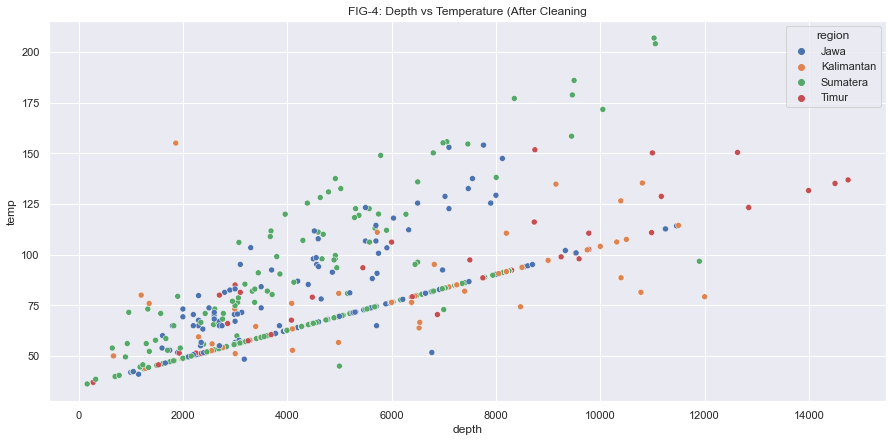

In [275]:
sns.scatterplot(x=esdc_raw.depth, y=esdc_raw.loc[~esdc_raw.temp.isna(), 'temp'], hue=esdc_raw.region)
plt.title('FIG-4: Depth vs Temperature (After Cleaning');

_Field Name_

> We notice that 1 field does'nt have field name but we decide to input this missing value in field_name by using dummy name as PETROGAS_FIELD

In [276]:
esdc_raw.loc[esdc_raw.field_name.isna(), :]

,fluid,field_name,operator,project_status,project_level,inplace,depth,temp,poro,perm,...,api_dens,visc,cap_cost,opr_cost,total_cost,avg_fluid_rate,location,region,NPV,PI
82,Gas,NaN,PETROGAS (BASIN) LTD.,ONSHORE,E0. On Production,15.2,8500.0,93.6879,0.208427,1843.266,...,0.707603,0.0,32.91079,6.594186,39.504976,7.070269,Papua Barat,Timur,12.41523,0.31427


In [277]:
esdc_raw.loc[esdc_raw.field_name.isna(), 'field_name'] = 'PETROGAS_FIELD'

In [278]:
total = esdc_raw.isnull().sum().sort_values(ascending=False)
percent = (esdc_raw.isnull().sum()/esdc_raw.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
fluid,0,0.0
api_dens,0,0.0
NPV,0,0.0
region,0,0.0
location,0,0.0
avg_fluid_rate,0,0.0
total_cost,0,0.0
opr_cost,0,0.0
cap_cost,0,0.0
visc,0,0.0


---
__Data Ready__

In [279]:
esdc_raw.to_csv('Data/esdc_df.csv')

In [293]:
esdc_raw.loc[:, 'PI'].describe()

count    734.000000
mean       1.272431
std        3.018720
min       -0.246133
25%        0.237052
50%        0.545711
75%        1.139363
max       61.262838
Name: PI, dtype: float64